# Práctica Luis Martín Vegas #
## Machine Learning 101 - Airbnb Predictive Model ##


Importamos los paquetes y librerias que vamos a utilizar para el procesado de los datos y el entrenamiento y evaluacion del modelo.

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers

### Carga de Datos y exploración inicial: ###

Cargamos el dataset Airbnb.csv

In [2]:
dataframe = pd.read_csv("/content/airbnb-listings.csv", sep = ";")
print("{} Registros con {} características".format(dataframe.shape[0], dataframe.shape[1]))

14780 Registros con 89 características


In [3]:
dataframe.dtypes

ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
                                   ...   
Cancellation Policy                object
Calculated host listings count    float64
Reviews per Month                 float64
Geolocation                        object
Features                           object
Length: 89, dtype: object

En primer lugar, filtramos los datos conservando solo las observaciones correspondientes a Madrid, para llevar a cabo un estudio específico de la ciudad.

In [4]:
dataframe = dataframe[dataframe["City"] == "Madrid"]
print("{} Registros con {} características para Ciudad = Madrid".format(dataframe.shape[0], dataframe.shape[1]))

13207 Registros con 89 características para Ciudad = Madrid


Tras una primera aproximacion al dataset, podemos apreciar errores al introducir los datos de ciertas variables, por ello procedemos a corregirlos:

In [5]:
# Aquellos errores para los que no podemos inferir el dato de que se trata serán reemplazados por valores nan:
dataframe["Zipcode"][dataframe["Zipcode"] == ""] = math.nan
dataframe["Zipcode"][dataframe["Zipcode"] == "-"] = math.nan
dataframe["Zipcode"][dataframe["Zipcode"] == "28"] = math.nan
dataframe["Zipcode"][dataframe["Zipcode"] == "1"] = math.nan

# Para aquellos casos en que se trata de un error de formato, los corregimos:
dataframe["Zipcode"][dataframe["Zipcode"] == "Madrid 28004"] = "28004"
dataframe["Zipcode"][dataframe["Zipcode"] == "28002\n28002"] = "28002"
dataframe["Zipcode"][dataframe["Zipcode"] == "28051\n28051"] = "28051"
dataframe["Zipcode"][dataframe["Zipcode"] == "280013"] = "28013"
dataframe["Zipcode"][dataframe["Zipcode"] == "2015"] = "28015"
dataframe["Zipcode"][dataframe["Zipcode"] == "2815"] = "28015"
dataframe["Zipcode"][dataframe["Zipcode"] == "2805"] = "28005"
dataframe["Zipcode"][dataframe["Zipcode"] == "2804"] = "28004"

# Comprobamos que no quedan valores extraños:
# dataframe["Zipcode"].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Procedemos a tratar de eliminar variables que sean irrelevantes para nuestro objeto de estudio y comprobamos que los datos están en el formato que necesitamos:

In [6]:
dataframe.columns
# dataframe.dtypes

# Eliminamos aquellas columnas que contienen IDs, descripciones, imagenes, URLs... que son irrelevantes para predecir el precio:
dataframe_pics = dataframe.drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 
                            'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview', 
                            'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 
                            'Medium Url', 'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
                            'Host Since', 'Host Location', 'Host About', 'Host Response Time', 'Host Response Rate', 
                            'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url', 'Host Total Listings Count', 
                            'Host Verifications', 'Street', 'Host Neighbourhood', 'Neighbourhood Cleansed', 
                            'Neighbourhood Group Cleansed', 'City', 'State', 'Market', 'Smart Location', 'Country Code', 
                            'Country', 'Weekly Price', 'Monthly Price', 'Calendar Updated', 'Has Availability', 
                            'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 
                            'Calendar last Scraped', 'First Review', 'Last Review', 'License', 'Jurisdiction Names', 
                            'Calculated host listings count', 'Geolocation', 'Features'], axis = 1)

dataframe = dataframe.drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 
                            'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview', 
                            'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url', 
                            'Medium Url', 'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
                            'Host Since', 'Host Location', 'Host About', 'Host Response Time', 'Host Response Rate', 
                            'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url', 'Host Total Listings Count', 
                            'Host Verifications', 'Street', 'Host Neighbourhood', 'Neighbourhood Cleansed', 
                            'Neighbourhood Group Cleansed', 'City', 'State', 'Market', 'Smart Location', 'Country Code', 
                            'Country', 'Weekly Price', 'Monthly Price', 'Calendar Updated', 'Has Availability', 
                            'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 
                            'Calendar last Scraped', 'First Review', 'Last Review', 'License', 'Jurisdiction Names', 
                            'Calculated host listings count', 'Geolocation', 'Features'], axis = 1)

# Comprobamos nuevamente las dimensiones del dataset objeto de estudio:
print("{} Registros con {} características para Ciudad = Madrid".format(dataframe.shape[0], dataframe.shape[1]))

13207 Registros con 31 características para Ciudad = Madrid


In [7]:
# Resumen de las variables que hemos conservado en nuestro dataframe:
# dataframe.describe().T

# Comprobamos si el dataframe contiene valores vacíos en las distintas variables:
# dataframe.isnull().any()
# dataframe.isnull().sum()

# Trataremos los NAs más adelante, una vez hayamos particionado el dataset en train y test set.

### PRE PROCESADO DE DATOS: ###

Llevamos a cabo la partición del dataframe en train y test, en formato array y separando la variable target de las variables independientes.

In [8]:
df_train, df_test = train_test_split(dataframe, test_size = 0.3, shuffle = True, random_state = 123)

print("TRAIN - {} Registros con {} características".format(df_train.shape[0], df_train.shape[1]))
print("TEST - {} Registros con {} características".format(df_test.shape[0], df_test.shape[1]))

TRAIN - 9244 Registros con 31 características
TEST - 3963 Registros con 31 características


### Preprocesado - TRAIN ###

Codificamos las variables categóricas con un label encoder y tratamos los valores NA:

In [9]:
# Tratamos las variables de tipo string, definimos y entrenamos un label encoder para cada una de las variables a codificar:

# Neighbourhood:
df_train["Neighbourhood"].fillna("Other", inplace=True)
enc1 = preprocessing.LabelEncoder()
enc1.fit(df_train["Neighbourhood"])
df_train["Neighbourhood"] = enc1.transform(df_train["Neighbourhood"])

# Property Type:
enc2 = preprocessing.LabelEncoder()
enc2.fit(df_train["Property Type"])
df_train["Property Type"] = enc2.transform(df_train["Property Type"])

# Room Type:
enc3 = preprocessing.LabelEncoder()
enc3.fit(df_train["Room Type"])
df_train["Room Type"] = enc3.transform(df_train["Room Type"])

# Bed Type:
enc4 = preprocessing.LabelEncoder()
enc4.fit(df_train["Bed Type"])
df_train["Bed Type"] = enc4.transform(df_train["Bed Type"])

# Cancellation Policy:
enc5 = preprocessing.LabelEncoder()
enc5.fit(df_train["Cancellation Policy"])
df_train["Cancellation Policy"] = enc5.transform(df_train["Cancellation Policy"])

# Comprobamos los tipos de variables resultantes tras la codificación:
# df_train.dtypes

Comprobamos si nuestro dataset tiene valores nulos o NAs y en su caso los tratamos. En función del tipo de variable de que se trate optaremos por reemplazarla por media/moda/mediana o por eliminarla en caso de que las observaciones con NA sean demasiadas. En todo caso nuestra prioridad será no alterar demasiado nuestros datos originales.

In [10]:
# Comprobamos la existencia de NAs para cada observación en nuestro dataframe (%):
NA = df_train.isna().sum()
# round(NA / len(df_train) * 100,2)

# Eliminamos las columnas cuyo porcentaje de NAs es demasiado alto como para considerarlas:
df_train = df_train.drop(["Square Feet"], axis=1)
df_train = df_train.drop(["Security Deposit"], axis=1)
df_train = df_train.drop(["Cleaning Fee"], axis=1)

In [11]:
# Tratamos las variables de forma independiente y en función de su naturaleza. En su mayoría optamos por reemplazar por 
# la moda para no alterar en exceso los datos:
df_train['Price'].fillna(df_train['Price'].mode()[0], inplace=True)

df_train["Neighbourhood"].fillna("Other", inplace=True)
df_train["Zipcode"].fillna(df_train["Zipcode"].mode()[0], inplace=True)
df_train["Host Listings Count"].fillna(df_train["Host Listings Count"].mode()[0], inplace=True)
df_train["Bedrooms"].fillna(df_train["Bedrooms"].mode()[0], inplace=True)
df_train["Bathrooms"].fillna(df_train["Bathrooms"].mode()[0], inplace=True)
df_train["Beds"].fillna(df_train["Beds"].mode()[0], inplace=True)
df_train["Price"].fillna(df_train["Price"].mode()[0], inplace=True)
df_train["Review Scores Rating"].fillna(df_train["Review Scores Rating"].mode()[0], inplace=True)
df_train["Review Scores Accuracy"].fillna(df_train["Review Scores Accuracy"].mode()[0], inplace=True)
df_train["Review Scores Cleanliness"].fillna(df_train["Review Scores Cleanliness"].mode()[0], inplace=True)
df_train["Review Scores Checkin"].fillna(df_train["Review Scores Checkin"].mode()[0], inplace=True)
df_train["Review Scores Communication"].fillna(df_train["Review Scores Communication"].mode()[0], inplace=True)
df_train["Review Scores Location"].fillna(df_train["Review Scores Location"].mode()[0], inplace=True)
df_train["Review Scores Value"].fillna(df_train["Review Scores Value"].mode()[0], inplace=True)
df_train["Reviews per Month"].fillna(df_train["Reviews per Month"].mode()[0], inplace=True)

# Para las amenities además de tratar los NAs, por tratarse de un listado, haremos un recuento:
df_train["Amenities"].fillna("", inplace=True)
df_train["Amenities"] = df_train["Amenities"].apply(lambda x: len(x.split(",")))

### Análisis Exploratorio ###

In [12]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Listings Count,9244.0,9.934552,27.663030,0.000000,1.000000,2.000000,5.000000,207.000000
Neighbourhood,9244.0,38.849091,14.686380,0.000000,30.000000,47.000000,47.000000,65.000000
Latitude,9244.0,40.420467,0.020057,40.331888,40.409996,40.418628,40.427790,40.514247
Longitude,9244.0,-3.697062,0.023561,-3.835498,-3.707811,-3.701594,-3.693721,-3.573613
Property Type,9244.0,1.961489,4.753405,0.000000,0.000000,0.000000,0.000000,20.000000
Room Type,9244.0,0.416595,0.518895,0.000000,0.000000,0.000000,1.000000,2.000000
Accommodates,9244.0,3.180658,1.969262,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,9244.0,1.247566,0.592124,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,9244.0,1.284942,0.819767,0.000000,1.000000,1.000000,1.000000,10.000000
Beds,9244.0,1.975660,1.501686,1.000000,1.000000,1.000000,2.000000,16.000000


Comprobamos posibles outliers gaficando los histogramas para las distintas variables y los descartamos para que no alteren nuestros resultados:

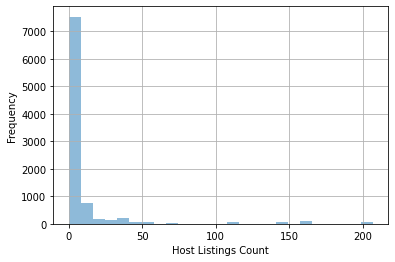

In [13]:
df_train['Host Listings Count'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Host Listings Count')

# Quitamos los outliers por encima de 200 publicaciones
df_train_clean = df_train[df_train['Host Listings Count'] < 200]

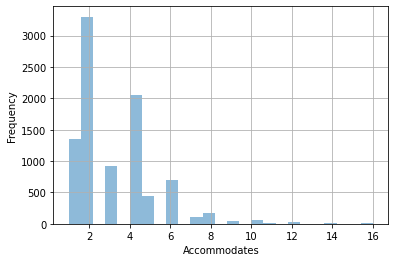

In [14]:
df_train_clean['Accommodates'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Accommodates')
df_train_clean['Accommodates'].value_counts()

# Quitamos los outliers por encima de 13:
df_train_clean = df_train_clean[df_train_clean['Accommodates'] < 13]

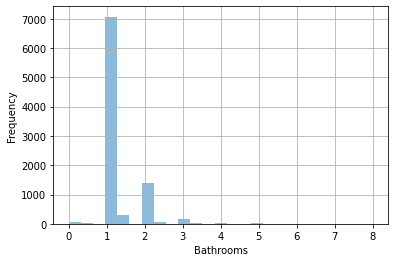

In [15]:
df_train_clean['Bathrooms'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Bathrooms')
df_train_clean['Bathrooms'].value_counts()

# Quitamos los outliers por encima de 6 baños:
df_train_clean = df_train_clean[df_train_clean['Bathrooms'] < 6]


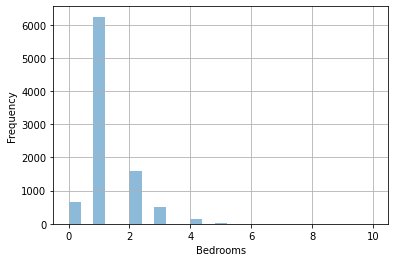

In [16]:
df_train_clean['Bedrooms'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Bedrooms')
df_train_clean['Bedrooms'].value_counts()

# Quitamos los outliers por encima de 6 habitaciones
df_train_clean = df_train_clean[df_train_clean['Bedrooms'] < 6]

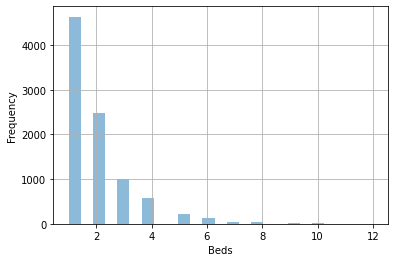

In [17]:
df_train_clean['Beds'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Beds')
df_train_clean['Beds'].value_counts()

# Quitamos los outliers por encima de 11 camas.
df_train_clean = df_train_clean[df_train_clean['Beds'] < 11]

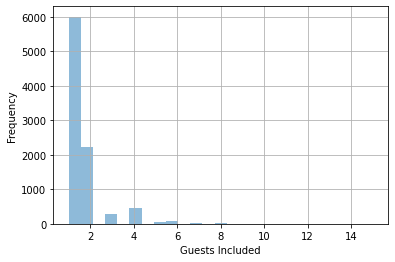

In [18]:
df_train_clean['Guests Included'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Guests Included')
df_train_clean['Guests Included'].value_counts()

# Quitamos los outliers por encima de 9 guests:
df_train_clean = df_train_clean[df_train_clean['Guests Included'] < 9]

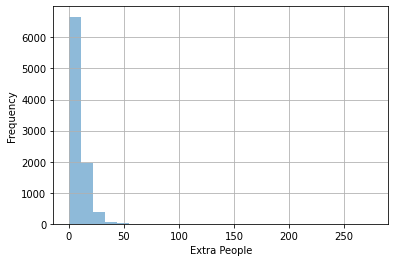

In [19]:
df_train_clean['Extra People'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Extra People')
df_train_clean['Extra People'].value_counts()

# Quitamos los outliers por encima de 50:
df_train_clean = df_train_clean[df_train_clean['Extra People'] < 50]

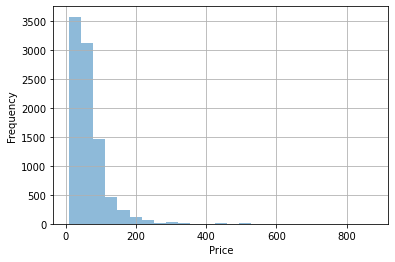

In [20]:
df_train_clean['Price'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Price')
df_train_clean['Price'].value_counts()

# Quitamos los outliers con precio superior a 400:
df_train_clean = df_train_clean[df_train_clean['Price'] < 400]

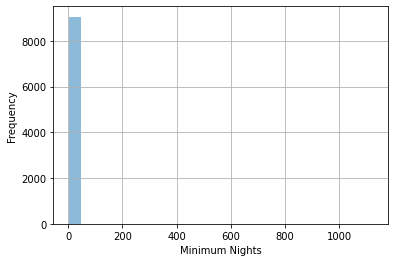

In [21]:
df_train_clean['Minimum Nights'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Minimum Nights')
df_train_clean['Minimum Nights'].value_counts()

# Quitamos los outliers superiores a 50:
df_train_clean = df_train_clean[df_train_clean['Minimum Nights'] < 50]

Comprobamos el porcentaje de muestras eliminadas al quitar outliers y verificamos nuestro nuevo tamaño muestral: 

In [22]:
porcentaje = (df_train.shape[0] - df_train_clean.shape[0])/(df_train.shape[0])*100
print("Porcentaje de observaciones eliminadas: {}%".format(porcentaje))
print("TRAIN CLEAN- {} Registros con {} características".format(df_train_clean.shape[0], df_train_clean.shape[1]))

Porcentaje de observaciones eliminadas: 2.087840761575076%
TRAIN CLEAN- 9051 Registros con 28 características


Graficamos la variable target, Price, frente a algunas variables dependientes.

In [23]:
# df_train_clean.plot(kind = "scatter",x="Host Listings Count",y = "Price")
# df_train_clean.boxplot(by="Room Type",column = "Price")
# df_train_clean.plot(kind = "scatter",x="Accommodates",y = "Price")
# df_train_clean.plot(kind = "scatter",x="Bathrooms",y = "Price")
# df_train_clean.plot(kind = "scatter",x="Bedrooms",y = "Price")
# df_train_clean.plot(kind = "scatter",x="Beds",y = "Price")
# df_train_clean.boxplot(by="Bed Type",column = "Price")
# df_train_clean.plot(kind = "scatter",x="Amenities",y = "Price")
# df_train_clean.plot(kind = "scatter",x="Guests Included",y = "Price")
# df_train_clean.plot(kind = "scatter",x="Extra People",y = "Price")
# df_train_clean.plot(kind = "scatter",x="Review Scores Rating",y = "Price")
# df_train_clean.boxplot(by="Cancellation Policy",column = "Price")
# df_train_clean.plot(kind = "scatter",x="Minimum Nights",y = "Price")

Comprobamos la correlación existente entre las variables para evitar casos de colinealidad y corregirlos en caso de haberlos.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


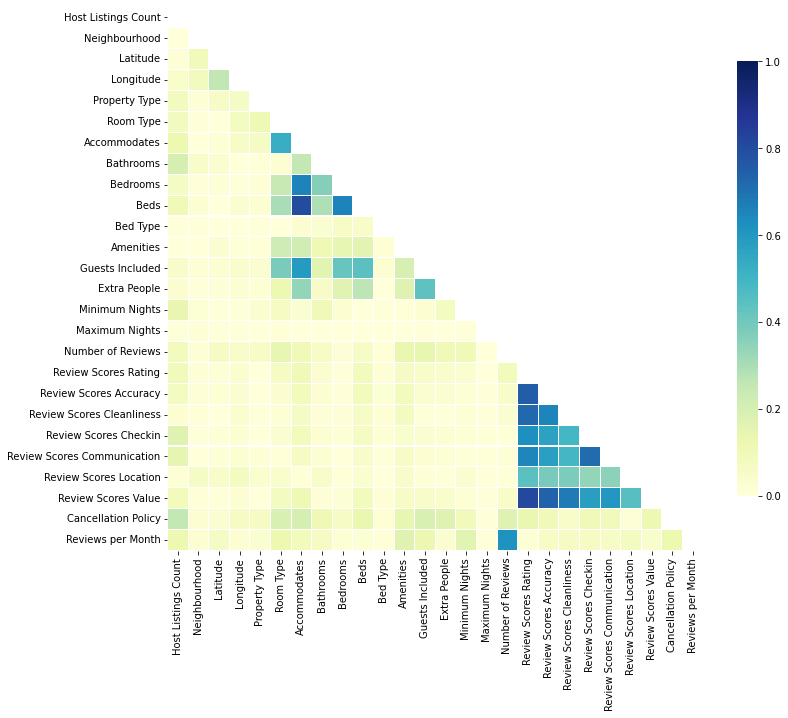

In [24]:
corr = np.abs(df_train_clean.drop(['Price'], axis=1).corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

Comprobamos que Review Scores Rating es un combinación de los demás ratings con lo que podemos eliminar las demás y quedarnos con la principal. Lo mismo sucede con Accomodates y el número de camas.

In [25]:
df_trainF = df_train_clean.drop(["Accommodates", "Review Scores Accuracy", "Review Scores Cleanliness", 
                                 "Review Scores Checkin", "Review Scores Communication", "Review Scores Location", 
                                 "Review Scores Value"], axis = 1)


Graficamos los Scatterplots de las distintas variables entre sí.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f571b862650>,
      dtype=object)

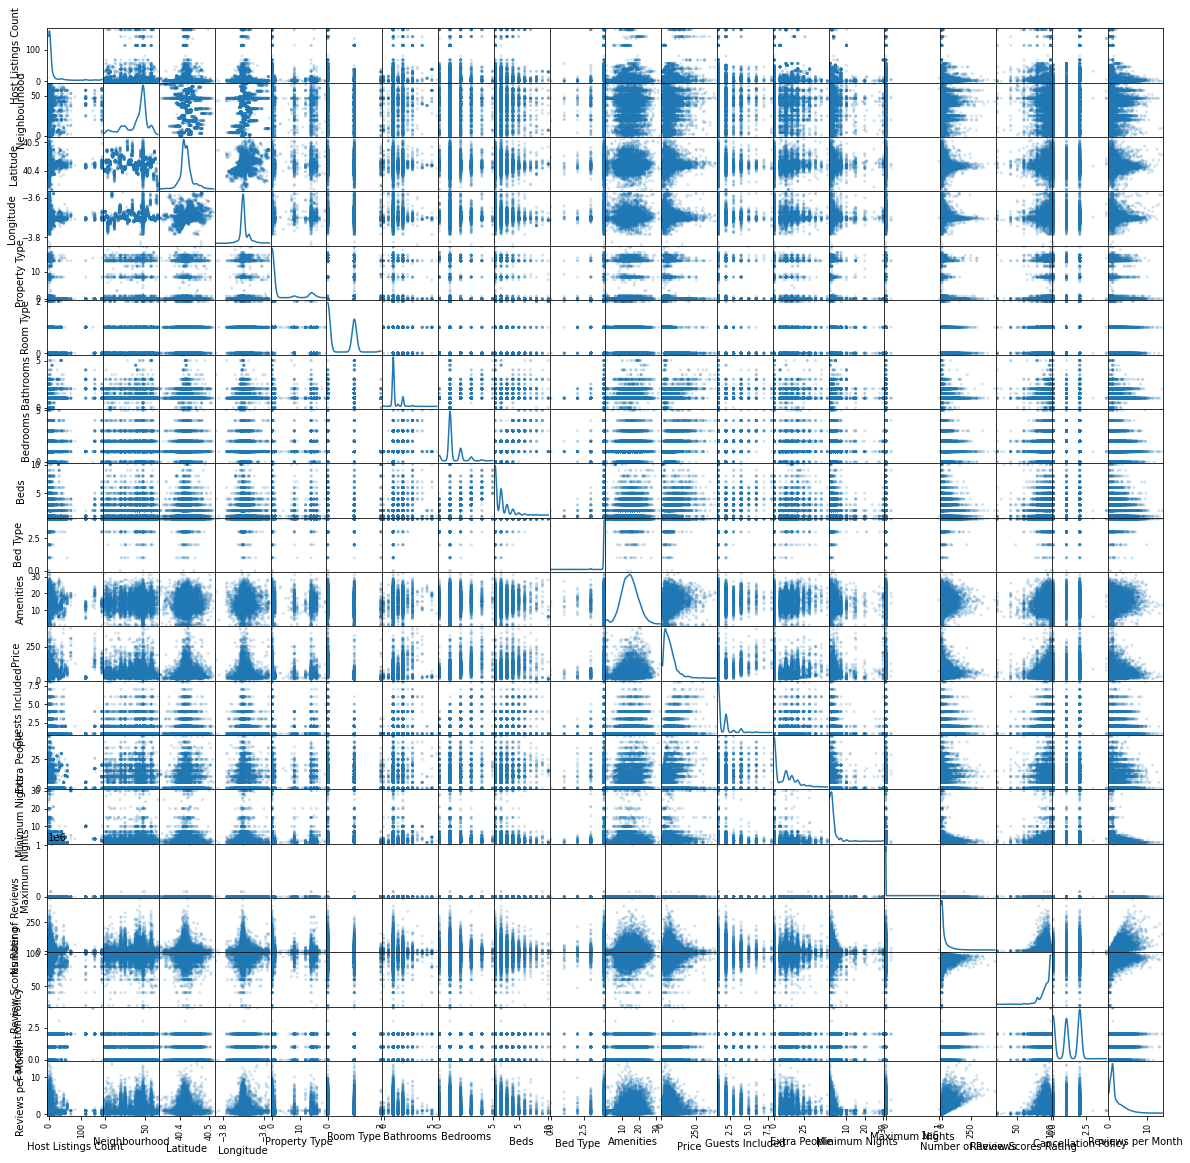

In [26]:
pd.plotting.scatter_matrix(df_trainF, alpha=0.2, figsize=(20, 20), diagonal = 'kde')

Defimimos Price como nuestra variable Target y la separamos de las variables dependientes objeto de estudio.

In [27]:
Y_train = df_trainF['Price']
X_train = df_trainF.drop(['Price'], axis=1)

Con el F test, podemos comprobar si hay alguna otra variable que podamos descartar por su escasa relevancia para nuestro objeto de estudio.

Text(0.5, 1.0, 'Mutual information score')

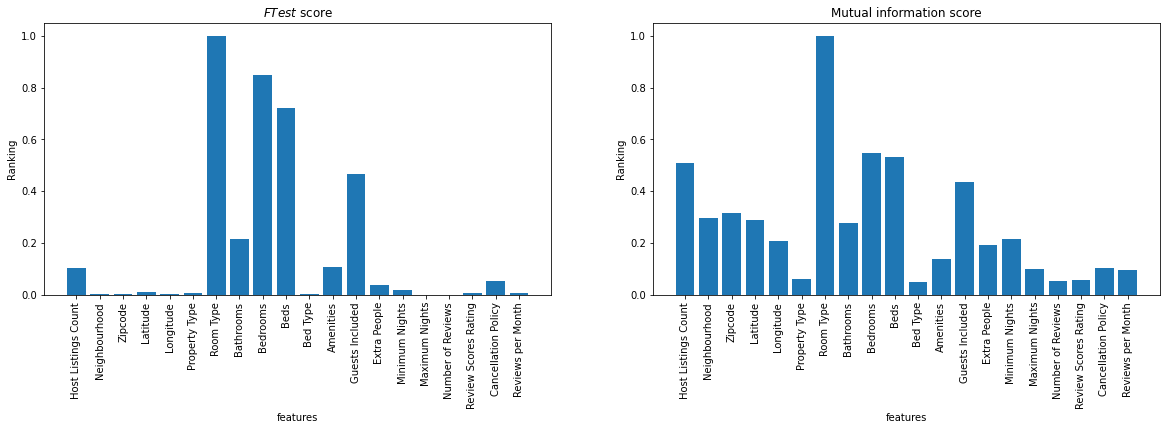

In [28]:
feature_names = X_train.columns
f_test, _ = f_regression(X_train, Y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(X_train, Y_train)
mi /= np.max(mi)

plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]), f_test,  align = "center")
plt.xticks(range(X_train.shape[1]), feature_names, rotation = 90)
plt.xlabel("features")
plt.ylabel("Ranking")
plt.title("$FTest$ score")

plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]), mi, align="center")
plt.xticks(range(X_train.shape[1]), feature_names, rotation = 90)
plt.xlabel("features")
plt.ylabel("Ranking")
plt.title("Mutual information score")

In [29]:
# Por su baja putnuación en el F-test, descartamos las siguientes variables:
X_train = X_train.drop(["Property Type", "Bed Type", "Maximum Nights"], axis=1)

### Preprocesado - TEST ###

Replicamos el preprocesado de Train para el conjunto de test:

In [30]:
columns = df_trainF.columns.tolist()
df_test = df_test[columns].drop(["Property Type", "Bed Type", "Maximum Nights"], axis=1)

print("{} Registros con {} características para Ciudad = Madrid".format(df_test.shape[0], df_test.shape[1]))

3963 Registros con 18 características para Ciudad = Madrid


Replicamos tanto el fill.na como el tratamiento de outliers:

In [31]:
df_test['Price'].fillna(df_test['Price'].mode()[0], inplace=True)

df_test["Neighbourhood"].fillna("Other", inplace=True)
df_test["Zipcode"].fillna(df_test["Zipcode"].mode()[0], inplace=True)
df_test["Host Listings Count"].fillna(df_test["Host Listings Count"].mode()[0], inplace=True)
df_test["Bedrooms"].fillna(df_test["Bedrooms"].mode()[0], inplace=True)
df_test["Bathrooms"].fillna(df_test["Bathrooms"].mode()[0], inplace=True)
df_test["Beds"].fillna(df_test["Beds"].mode()[0], inplace=True)
df_test["Price"].fillna(df_test["Price"].mode()[0], inplace=True)
df_test["Review Scores Rating"].fillna(df_test["Review Scores Rating"].mode()[0], inplace=True)
df_test["Reviews per Month"].fillna(df_test["Reviews per Month"].mode()[0], inplace=True)

df_test = df_test[df_test['Host Listings Count'] < 200]
df_test = df_test[df_test['Bathrooms'] < 6]
df_test = df_test[df_test['Bedrooms'] < 6]
df_test = df_test[df_test['Beds'] < 11]
df_test = df_test[df_test['Guests Included'] < 9]
df_test = df_test[df_test['Extra People'] < 50]
df_test = df_test[df_test['Price'] < 400]
df_test = df_test[df_test['Minimum Nights'] < 50]

df_test["Amenities"].fillna("", inplace=True)
df_test["Amenities"] = df_test["Amenities"].apply(lambda x: len(x.split(",")))

Ejecutamos también el label encoder que hemos entrenado en train:

In [32]:
df_test["Neighbourhood"] = enc1.transform(df_test["Neighbourhood"])
df_test["Room Type"] = enc3.transform(df_test["Room Type"])
df_test["Cancellation Policy"] = enc5.transform(df_test["Cancellation Policy"])

Separamos la variable target de las variables dependientes también en el test set:

In [33]:
Y_test = df_test['Price']
X_test = df_test.drop(['Price'], axis=1)

### Escalado de los datos ###

Escalamos la variable target dividiendo entre el precio máximo en train:

In [34]:
maxPrice = df_trainF["Price"].max()

In [35]:
Y_train = Y_train.apply(lambda x: x/maxPrice)
Y_test = Y_test.apply(lambda x: x/maxPrice)

print("Train Max: {} // Train Min: {} \n Test Max: {} // Test Min: {}" 
      .format(Y_train.max(), Y_train.min(), Y_test.max(), Y_test.min()))

Train Max: 1.0 // Train Min: 0.023076923076923078 
 Test Max: 1.0128205128205128 // Test Min: 0.02564102564102564


Reescalamos las variables dependientes con un escalado Min-Max:

In [36]:
# El reescalado únicamente se puede llevar a cabo para variables continuas.:
continuous = ["Neighbourhood", "Zipcode", "Latitude", "Longitude", "Room Type", "Bathrooms", "Bedrooms", 
              "Beds","Amenities","Guests Included","Extra People","Minimum Nights","Number of Reviews", 
              "Review Scores Rating", "Cancellation Policy", "Reviews per Month"]

cs = MinMaxScaler()
X_train = cs.fit_transform(X_train[continuous])
X_test = cs.transform(X_test[continuous])

Comenzamos el entreno de nuestra red Neuronal. Se trata de un modelo hibrido por el que en primer lugar analizaremos las variables numéricas y categóricas para después llevar a cabo un estudio de las imágenes adjuntas y combinar ambos resultados.

Graficamos un histograma de la variable dependiente para comprobar si nos es más útil trabajar con algún tipo de transformación:

(array([ 27.,  22.,  36.,  25., 146., 267., 352., 236., 457., 521., 447.,
        526., 436., 631., 371., 764., 659., 547., 426., 390., 194., 213.,
        160.,  70.,  98.,  40.,  40.,  15.,  20.,   9.]),
 array([-1.6368221 , -1.58244816, -1.52807422, -1.47370028, -1.41932633,
        -1.36495239, -1.31057845, -1.25620451, -1.20183057, -1.14745663,
        -1.09308269, -1.03870875, -0.98433481, -0.92996087, -0.87558693,
        -0.82121299, -0.76683905, -0.71246511, -0.65809117, -0.60371722,
        -0.54934328, -0.49496934, -0.4405954 , -0.38622146, -0.33184752,
        -0.27747358, -0.22309964, -0.1687257 , -0.11435176, -0.05997782,
        -0.00560388]),
 <a list of 30 Patch objects>)

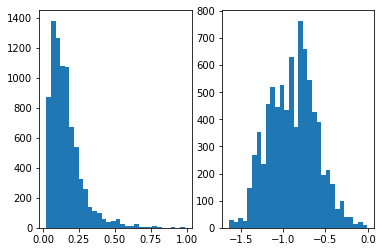

In [39]:
plt.subplot(1,2,1)
plt.hist(Y_train, bins=30)
plt.subplot(1,2,2)
plt.hist(np.log10(Y_train), bins=30)

Como podemos comprobar, nos es util trabajar con el logaritmo del precio, ya que los algoritmos de Machine Learning tienden a estar optimizados o pensados para distribuciones próximas a la normal.

Recurrimos a Lasso para seleccion de variables:

best mean cross-validation score: -0.029
best parameters: {'alpha': 4.094915062380427e-05}


Text(0, 0.5, '5-Fold MSE')

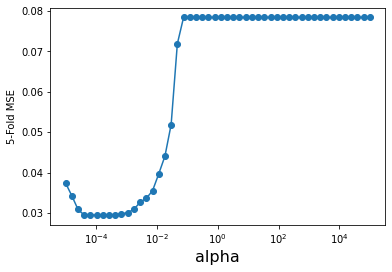

In [41]:
alpha_vector_lasso = np.logspace(-5,5,50)
param_grid_lasso = {'alpha': alpha_vector_lasso}
grid_lasso = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid_lasso, cv = 5)
grid_lasso.fit(X_train, np.log10(Y_train))
print("best mean cross-validation score: {:.3f}".format(grid_lasso.best_score_))
print("best parameters: {}".format(grid_lasso.best_params_))
scores = -1*np.array(grid_lasso.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector_lasso,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')

Hacemos zoom:

best mean cross-validation score: -0.030
best parameters: {'alpha': 0.001}


Text(0, 0.5, '5-Fold MSE')

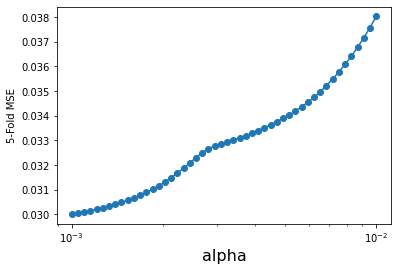

In [42]:
alpha_vector_lasso = np.logspace(-3,-2,50)  # hacemos zoom
param_grid_lasso = {'alpha': alpha_vector_lasso}
grid_lasso = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid_lasso, cv = 5)
grid_lasso.fit(X_train, np.log10(Y_train))
print("best mean cross-validation score: {:.3f}".format(grid_lasso.best_score_))
print("best parameters: {}".format(grid_lasso.best_params_))
scores = -1*np.array(grid_lasso.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector_lasso,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')

Seleccionamos el valor óptimo:

In [44]:
alpha_optimo_lasso = grid_lasso.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo_lasso).fit(X_train, np.log10(Y_train))
ytrainLasso = lasso.predict(X_train)
ytestLasso  = lasso.predict(X_test)
mseTrainModelLasso = mean_squared_error(Y_train,pow(10, ytrainLasso))
mseTestModelLasso = mean_squared_error(Y_test, pow(10,  ytestLasso))
print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)
print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))
w_lasso = lasso.coef_
for f,wi in zip(feature_names,w_lasso):
    print(f,wi)

MSE Modelo Lasso (train): 0.00665
MSE Modelo Lasso (test) : 0.0077
RMSE Modelo Lasso (train): 0.0815
RMSE Modelo Lasso (test) : 0.0878
Host Listings Count 0.0425470593341719
Neighbourhood -0.0
Zipcode 0.11250682197011083
Latitude -0.0
Longitude -0.6540548847087004
Property Type 0.13328073995390335
Room Type 0.30654336463111104
Bathrooms 0.17131709524762903
Bedrooms 0.06607513886230704
Beds 0.12207952281955729
Bed Type -0.0
Amenities -0.0
Guests Included -0.0
Extra People 0.1551735291205759
Minimum Nights 0.0
Maximum Nights -0.1314093136415453


Entrenamos un modelo con Ridge Regression:

best mean cross-validation score: 0.623
best parameters: {'alpha': 10.0}


Text(0, 0.5, '5-Fold MSE')

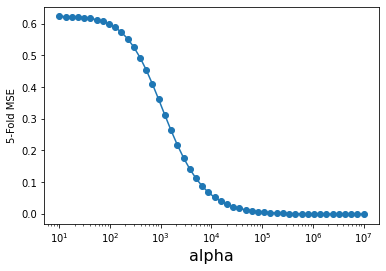

In [47]:
alpha_vector_ridge = np.logspace(1,7,50)
param_grid_ridge = {'alpha': alpha_vector_ridge}
grid_ridge = GridSearchCV(Ridge(), param_grid=param_grid_ridge, cv = 5)
grid_ridge.fit(X_train, np.log10(Y_train))
print("best mean cross-validation score: {:.3f}".format(grid_ridge.best_score_))
print("best parameters: {}".format(grid_ridge.best_params_))
scores = np.array(grid_ridge.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector_ridge,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')

best mean cross-validation score: 0.623
best parameters: {'alpha': 10.0}


Text(0, 0.5, '5-Fold MSE')

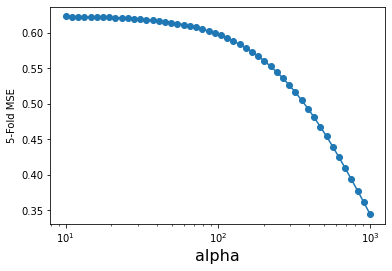

In [48]:
alpha_vector_ridge = np.logspace(1,3,50) # hacemos zoom
param_grid_ridge = {'alpha': alpha_vector_ridge}
grid_ridge = GridSearchCV(Ridge(), param_grid=param_grid_ridge, cv = 5)
grid_ridge.fit(X_train, np.log10(Y_train))
print("best mean cross-validation score: {:.3f}".format(grid_ridge.best_score_))
print("best parameters: {}".format(grid_ridge.best_params_))
scores = np.array(grid_ridge.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector_ridge,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')

In [49]:
alpha_optimo_ridge = grid_ridge.best_params_['alpha']
ridge = Ridge(alpha = alpha_optimo_ridge).fit(X_train,np.log10(Y_train))
ytrainRidge = ridge.predict(X_train)
ytestRidge  = ridge.predict(X_test)
mseTrainModelRidge = mean_squared_error(Y_train,pow(10,ytrainRidge))
mseTestModelRidge = mean_squared_error(Y_test, pow(10, ytestRidge))
print('MSE Modelo Ridge (train): %0.3g' % mseTrainModelRidge)
print('MSE Modelo Ridge (test) : %0.3g' % mseTestModelRidge)
print('RMSE Modelo Ridge (train): %0.3g' % np.sqrt(mseTrainModelRidge))
print('RMSE Modelo Ridge (test) : %0.3g' % np.sqrt(mseTestModelRidge))
w_ridge = ridge.coef_
for f,wi in zip(feature_names,w_ridge):
    print(f,wi)

MSE Modelo Ridge (train): 0.00641
MSE Modelo Ridge (test) : 0.0074
RMSE Modelo Ridge (train): 0.0801
RMSE Modelo Ridge (test) : 0.086
Host Listings Count 0.06518769968125421
Neighbourhood -0.013442281932724646
Zipcode 0.19287562174477424
Latitude -0.08187019416592543
Longitude -0.644885288388635
Property Type 0.18741678155971206
Room Type 0.2875884671672953
Bathrooms 0.19973586512422015
Bedrooms 0.10146774665593034
Beds 0.1771827559613542
Bed Type -0.04129675411000453
Amenities -0.040397325104381966
Guests Included -0.004752187576984445
Extra People 0.22314398783014833
Minimum Nights 0.020146022055818252
Maximum Nights -0.19461458044948837


Los resultados de ambos modelos son muy similares, no obstante, con Lasso hemos podido descartar 2 de las variables independientes, lo que supone una simplificación del modelo manteniendo un error similar, siendo por tanto un modelo mejor, más óptimo.

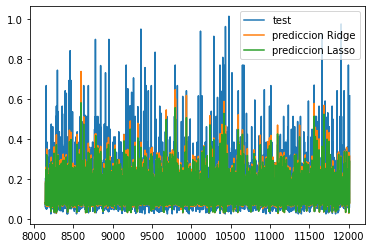

In [50]:
plt.plot(range(len(Y_train),len(Y_train)+len(Y_test)),Y_test,label='test')
plt.plot(range(len(Y_train),len(Y_train)+len(Y_test)),pow(10, ytestRidge),label='prediccion Ridge')
plt.plot(range(len(Y_train),len(Y_train)+len(Y_test)),pow(10, ytestLasso),label='prediccion Lasso')
plt.legend()